# OpenMP K-Means 1D 

## 1. OpenMP C Code

In [4]:
%%writefile kmeans_omp.c
#define _POSIX_C_SOURCE 200809L
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>
#include <omp.h>
#include <errno.h>

#define CACHE_LINE_SIZE 64

#ifdef _WIN32
#include <malloc.h>
static int posix_memalign(void **memptr, size_t alignment, size_t size) {
    *memptr = _aligned_malloc(size, alignment);
    if (*memptr == NULL) return ENOMEM;
    return 0;
}
static void aligned_free(void *ptr) {
    _aligned_free(ptr);
}
#else
static void aligned_free(void *ptr) {
    free(ptr);
}
#endif

/* ---------- util CSV 1D: cada linha tem 1 número ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }

    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }

    char line[8192];
    int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;
        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); fclose(f); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f);
    *n_out = R;
    return A;
}

static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

/* Helper to calculate padded size to align to cache line */
static size_t get_padded_size(size_t size) {
    return (size + CACHE_LINE_SIZE - 1) & ~(CACHE_LINE_SIZE - 1);
}

/* ---------- k-means 1D ---------- */
static double assignment_step_1d(const double *X, const double *C, int *assign, int N, int K){
    double sse = 0.0;

    // schedule(runtime) permite controlar 'static'/'dynamic' e chunk via 'OMP_SCHEDULE'
    #pragma omp parallel for reduction(+:sse) schedule(runtime)
    for(int i=0;i<N;i++){
        int best = -1;
        double bestd = 1e300;
        for(int c=0;c<K;c++){
            double diff = X[i] - C[c];
            double d = diff*diff;
            if(d < bestd){ bestd = d; best = c; }
        }
        assign[i] = best;
        sse += bestd;
    }
    return sse;
}

static void update_step_1d(const double *X, double *C, const int *assign, int N, int K) {
    double *sum = (double*)calloc((size_t)K, sizeof(double));
    int *cnt = (int*)calloc((size_t)K, sizeof(int));
    int n_threads = omp_get_max_threads();

    // Calculate padded sizes for thread-private arrays to avoid false sharing
    size_t sum_size = K * sizeof(double);
    size_t cnt_size = K * sizeof(int);
    size_t sum_stride = get_padded_size(sum_size);
    size_t cnt_stride = get_padded_size(cnt_size);

    double *sum_private = NULL;
    int *cnt_private = NULL;

    // Use posix_memalign for cache line alignment
    if (posix_memalign((void**)&sum_private, CACHE_LINE_SIZE, n_threads * sum_stride) != 0) {
        fprintf(stderr, "Sem memoria no update (sum_private)\n");
        exit(1);
    }
    if (posix_memalign((void**)&cnt_private, CACHE_LINE_SIZE, n_threads * cnt_stride) != 0) {
        fprintf(stderr, "Sem memoria no update (cnt_private)\n");
        aligned_free(sum_private);
        exit(1);
    }

    // Initialize to 0 (posix_memalign content is undefined)
    memset(sum_private, 0, n_threads * sum_stride);
    memset(cnt_private, 0, n_threads * cnt_stride);

    if (!sum || !cnt) {
        fprintf(stderr, "Sem memoria no update\n");
        free(sum);
        free(cnt);
        aligned_free(sum_private);
        aligned_free(cnt_private);
        exit(1);
    }

    #pragma omp parallel
    {
      int id = omp_get_thread_num();
      // Access private data with padding stride
      double *my_sum = (double*)((char*)sum_private + id * sum_stride);
      int *my_cnt = (int*)((char*)cnt_private + id * cnt_stride);

      #pragma omp for schedule(runtime)
        for (int i = 0; i < N; i++) {
            int a = assign[i];
            if (a >= 0 && a < K) {
                my_cnt[a] += 1;
                my_sum[a] += X[i];
            }
        }

      #pragma omp for schedule(runtime)
        for (int c = 0; c < K; c++) {
          for (int t = 0; t < n_threads; t++) {
             // Access private data with padding stride
            double *t_sum = (double*)((char*)sum_private + t * sum_stride);
            int *t_cnt = (int*)((char*)cnt_private + t * cnt_stride);
            sum[c] += t_sum[c];
            cnt[c] += t_cnt[c];
          }
        }
    }

    for (int c = 0; c < K; c++) {
      if (cnt[c] > 0)
        C[c] = sum[c] / (double)cnt[c];
      else
        C[c] = X[0];
    }
    free(sum);
    free(cnt);
    aligned_free(sum_private);
    aligned_free(cnt_private);
}

static void kmeans_1d(const double *X, double *C, int *assign,
                      int N, int K, int max_iter, double eps,
                      int *iters_out, double *sse_out)
{
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;
    for(it=0; it<max_iter; it++){
        sse = assignment_step_1d(X, C, assign, N, K);

        // --- MODIFICAÇÃO: Imprime SSE a cada iteração para validação ---
        printf("SSE_ITER: %d %.6f\n", it, sse);

        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);
        if(rel < eps){ it++; break; }
        update_step_1d(X, C, assign, N, K);
        prev_sse = sse;
    }
    *iters_out = it;
    *sse_out = sse;
}

/* ---------- main ---------- */
int main(int argc, char **argv){
    if(argc < 3){
        printf("Uso: %s dados.csv centroides_iniciais.csv [max_iter=50] [eps=1e-4] [assign.csv] [centroids.csv]\n", argv[0]);
        return 1;
    } 

    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int max_iter = (argc>3)? atoi(argv[3]) : 50;
    double eps   = (argc>4)? atof(argv[4]) : 1e-4;
    const char *outAssign   = (argc>5)? argv[5] : NULL;
    const char *outCentroid = (argc>6)? argv[6] : NULL;

    if(max_iter <= 0 || eps <= 0.0){
        fprintf(stderr,"Parâmetros inválidos: max_iter>0 e eps>0\n");
        return 1;
    }

    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    double *C = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C); return 1; }

    // para medir tempo
    double t0 = omp_get_wtime();
    int iters = 0; double sse = 0.0;
    kmeans_1d(X, C, assign, N, K, max_iter, eps, &iters, &sse);
    double t1 = omp_get_wtime();
    double ms = 1000.0 * (t1 - t0);

    // Imprimir em stderr para não poluir o stdout (que o Python lerá)
    fprintf(stderr, "K-means 1D (OpenMP Fixed)\n");
    fprintf(stderr, "N=%d K=%d max_iter=%d eps=%g\n", N, K, max_iter, eps);
    fprintf(stderr, "Threads: %d\n", omp_get_max_threads());
    fprintf(stderr, "Iterações: %d | SSE final: %.6f | Tempo: %.1f ms\n", iters, sse, ms);

    printf("FINAL_DATA: Time=%.1f Threads=%d SSE=%.6f Iters=%d N=%d K=%d\n",
           ms, omp_get_max_threads(), sse, iters, N, K);

    write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C, K);

    free(assign); free(X); free(C);
    return 0;
}


Overwriting kmeans_omp.c


## 2. Compilação

In [5]:
!gcc -O2 -std=c99 -fopenmp kmeans_omp.c -o kmeans_omp -lm

## 3. Executar experimentos

Running experiments...
Threads: 1, Time: 45.0 ms, SSE: 3826358.595087
Threads: 2, Time: 27.0 ms, SSE: 3826358.595087
Threads: 4, Time: 17.0 ms, SSE: 3826358.595087
Threads: 8, Time: 17.0 ms, SSE: 3826358.595087
Threads: 16, Time: 18.0 ms, SSE: 3826358.595087

Results:
   Threads  Time_ms           SSE   Speedup
0        1     45.0  3.826359e+06  1.000000
1        2     27.0  3.826359e+06  1.666667
2        4     17.0  3.826359e+06  2.647059
3        8     17.0  3.826359e+06  2.647059
4       16     18.0  3.826359e+06  2.500000


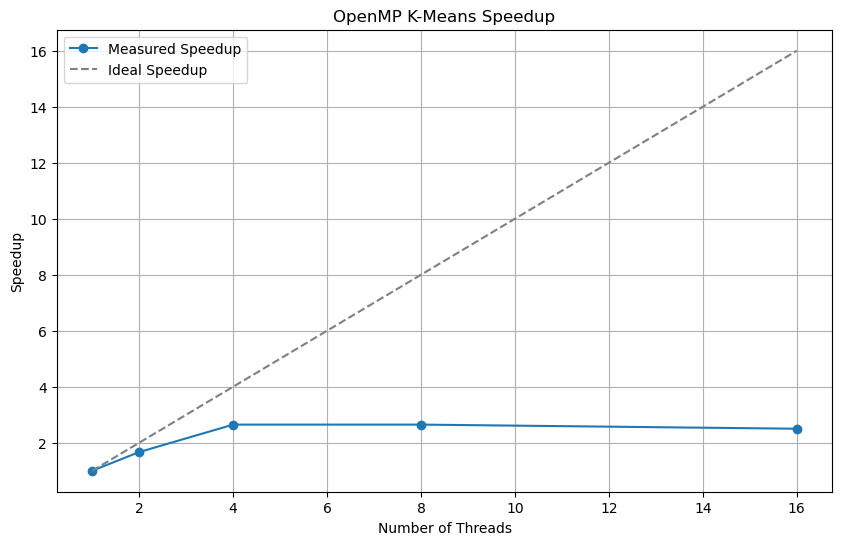

In [6]:
import os
import subprocess
import re
import pandas as pd
import matplotlib.pyplot as plt

def run_experiment(threads, schedule="static", chunk=4096):
    env = os.environ.copy()
    env["OMP_NUM_THREADS"] = str(threads)
    env["OMP_SCHEDULE"] = f"{schedule},{chunk}"

    cmd = [
        "./kmeans_omp",
        "../dataset/dados.csv",
        "../dataset/centroides_iniciais.csv",
        "50", "1e-6",
        f"assign_T{threads}.csv",
        f"centroids_T{threads}.csv"
    ]

    result = subprocess.run(cmd, capture_output=True, text=True, env=env)
    
    # Parse output
    match = re.search(r"FINAL_DATA: Time=([\d\.]+) Threads=(\d+) SSE=([\d\.]+)", result.stdout)
    if match:
        return {
            "Threads": int(match.group(2)),
            "Time_ms": float(match.group(1)),
            "SSE": float(match.group(3))
        }
    return None

results = []
thread_counts = [1, 2, 4, 8, 16]

print("Running experiments...")
for t in thread_counts:
    res = run_experiment(t)
    if res:
        results.append(res)
        print(f"Threads: {res['Threads']}, Time: {res['Time_ms']} ms, SSE: {res['SSE']}")

df = pd.DataFrame(results)
if not df.empty:
    base_time = df[df['Threads'] == 1]['Time_ms'].values[0]
    df['Speedup'] = base_time / df['Time_ms']
    print("\nResults:")
    print(df)

    # Plot Speedup
    plt.figure(figsize=(10, 6))
    plt.plot(df['Threads'], df['Speedup'], marker='o', label='Measured Speedup')
    plt.plot(df['Threads'], df['Threads'], linestyle='--', color='gray', label='Ideal Speedup')
    plt.title('OpenMP K-Means Speedup')
    plt.xlabel('Number of Threads')
    plt.ylabel('Speedup')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No results collected.")